# imports and data uploads

In [1]:
import os
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from os.path import join
from os import makedirs
from operator import pos
from matplotlib.gridspec import GridSpec
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from moseq2_app.gui.progress import update_progress, restore_progress_vars
from moseq2_viz.model.util import relabel_by_usage, parse_model_results, compute_syllable_explained_variance, compute_behavioral_statistics
from moseq2_viz.model.fingerprint_classifier import create_fingerprint_dataframe
from moseq2_viz.util import parse_index, read_yaml
from moseq2_viz.scalars.util import scalars_to_dataframe

plt.rcParams["pdf.fonttype"] = 42

In [2]:
# upload data
cpath = os.getcwd() #assumes mean_df_females is in the same path as the notebook
mean_df = pd.read_csv(cpath+'/mean_df_female.csv')
scalar_df = pd.read_csv(cpath+'/scalar_df_female.csv')

In [3]:
scalar_df['phase'] = scalar_df['group']
mean_df['phase']= mean_df['group']

# ----------------------------------------------------------------------- 
# ANALYSIS
# -----------------------------------------------------------------------

In [4]:
# plot/colors definitions
data_loc=cpath+'/figs/'
try:
    os.mkdir(data_loc)
except FileExistsError:
    # directory already exists
    pass

plt.style.use("seaborn-paper")

In [18]:
pxmm = scalar_df.area_mm.mean()/scalar_df.area_px.mean()
scalar_df['dist_to_center_mm'] = scalar_df['dist_to_center_px']*pxmm
mean_df['dist_to_center_mm'] = mean_df['dist_to_center_px']*pxmm

In [19]:
def plotting_fingerprint(summary, save_dir, range_dict, preprocessor=None, num_level = 1, level_names = ['Group'], vmin = None, vmax = None,
                         plot_columns=['dist_to_center_mm', 'velocity_2d_mm', 'height_ave_mm', 'length_mm', 'MoSeq'],
                         col_names=[('Position','Dist. from center (mm)'), ('Speed', 'Speed (mm/s)'), ('Height', 'Height (mm)'), ('Length', 'Length (mm)'), ('MoSeq','Syllable ID')]):
    
    # ensure number of groups is not over the number of available levels
    if num_level > len(summary.index.names):
        raise Exception('Too many levels to unpack. num_level should be less than', len(summary.index.names))

    name_map = dict(zip(plot_columns, col_names))
    
    levels = []
    level_plot = []
    level_ticks = []
    for i in range(num_level):
        print('number of levels', num_level)
        level = summary.index.get_level_values(i)
        level_label = LabelEncoder().fit_transform(level)
        find_mid = (np.diff(np.r_[0,np.argwhere(np.diff(level_label)).ravel(),len(level_label)])/2).astype('int32')
        # store level value
        levels.append(level)
        level_plot.append(level_label)
        level_ticks.append(np.r_[0,np.argwhere(np.diff(level_label)).ravel()] + find_mid)
    
    # col_num = number of grouping/level + column in summary
    col_num = num_level + len(plot_columns)

    # https://matplotlib.org/stable/tutorials/intermediate/gridspec.html
    fig = plt.figure(1, figsize=(20, 18), facecolor='white')

    gs = GridSpec(2, col_num, wspace=0.1, hspace=0.1,
              width_ratios=[1]*num_level+[8]*(col_num-num_level), height_ratios = [10,0.1], figure=fig)

    # plot the level(s)
    for i in range(num_level):
        temp_ax = fig.add_subplot(gs[0,i])
        temp_ax.set_title(level_names[i], fontsize=20)
        temp_ax.imshow(level_plot[i][:,np.newaxis], aspect = 'auto', cmap = 'tab20')
        plt.yticks(level_ticks[i], levels[i][level_ticks[i]], fontsize=20)
        
        temp_ax.get_xaxis().set_ticks([])
    
    # compile data to plot while recording vmin and vmax in the data
    plot_dict = {}
    # initialize vmin and vmax
    temp_vmin = np.Inf
    temp_vmax = -np.Inf
    
    for col in plot_columns:
        data = summary[col].to_numpy()
        # process data with preprocessor
        if preprocessor is not None:

            data = preprocessor.fit_transform(data.T).T

        if np.min(data) < temp_vmin:
            temp_vmin = np.min(data)
        if np.max(data) > temp_vmax:
            temp_vmax = np.max(data)

        plot_dict[col] = data
    
    if vmin is None:
        vmin = temp_vmin
    if vmax is None:
        vmax = temp_vmax

    # plot the data
    for i, col in enumerate(plot_columns):
        name = name_map[col]
        temp_ax = fig.add_subplot(gs[0, i + num_level])
        temp_ax.set_title(name[0], fontsize=20)
        data = plot_dict[col]
        
        # top to bottom is 0-20 for y axis
        if col == 'MoSeq':
            extent = [summary[col].columns[0], summary[col].columns[-1], len(summary) - 1, 0]
        else:
            extent = [range_dict[col].iloc[0], range_dict[col].iloc[1], len(summary) - 1, 0]

        pc = temp_ax.imshow(data, aspect='auto', interpolation='none', vmin=vmin, vmax=vmax, extent=extent, cmap='viridis')
        temp_ax.set_xlabel(name[1], fontsize=10)
        temp_ax.set_xticks(np.linspace(np.ceil(extent[0]), np.floor(extent[1]), 6).astype(int))
        temp_ax.set_yticks([])
        temp_ax.axis = 'tight'
    
    # plot colorbar
    cb = fig.add_subplot(gs[1,-1])  
    plt.colorbar(pc, cax=cb, orientation='horizontal')

    # specify labels for feature scaling
    if preprocessor:
        cb.set_xlabel('Min Max')
    else:
        cb.set_xlabel('Percentage Usage')
    
    fig.savefig(join(save_dir, 'moseq_fingerprint.pdf'))
    fig.savefig(join(save_dir, 'moseq_fingerprint.png'))

number of levels 1


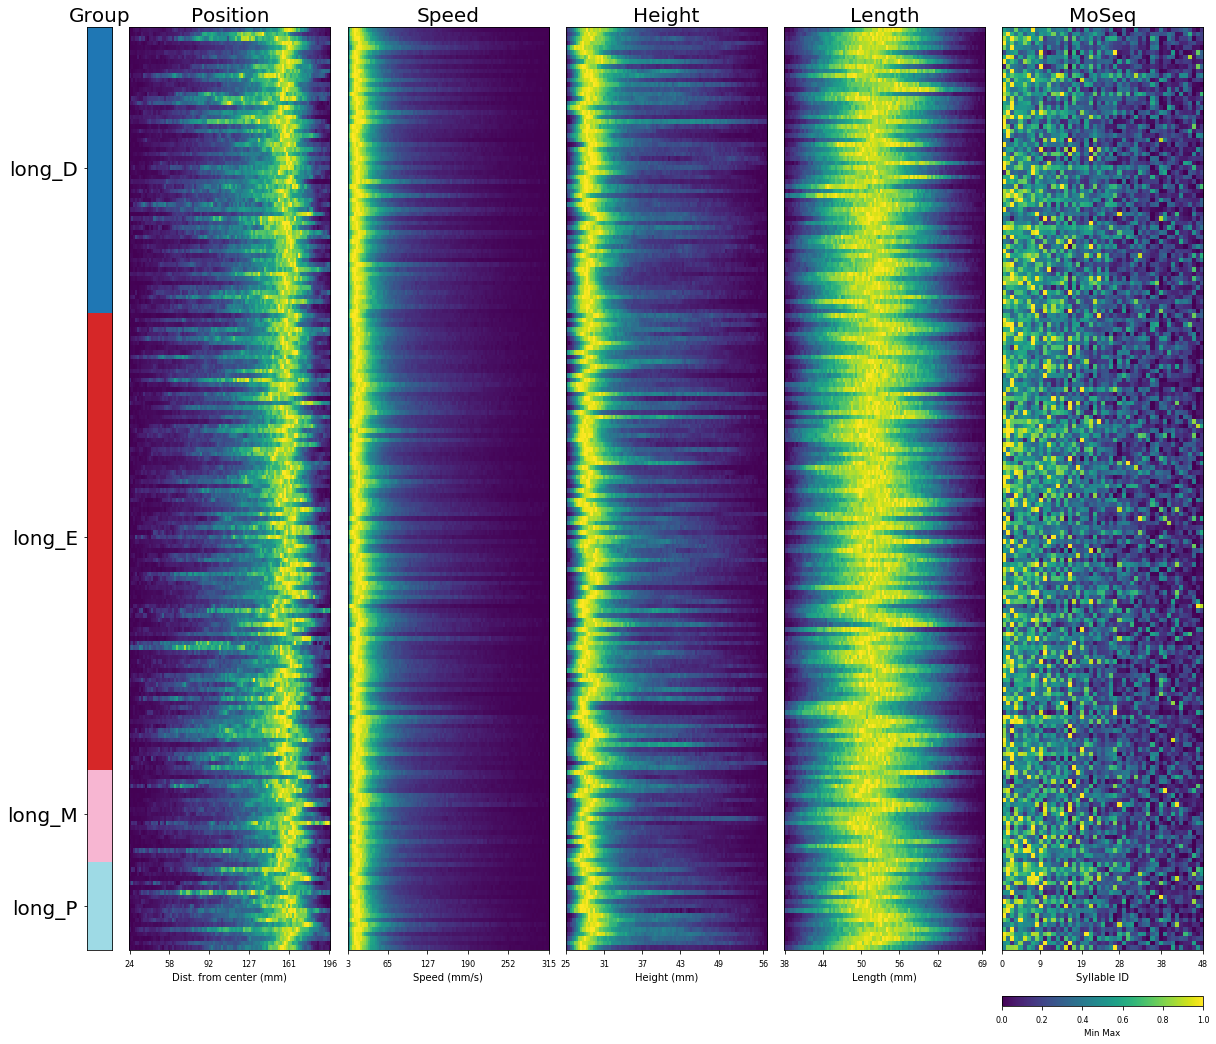

In [20]:
stat_type = 'mean'
n_bins = 100  # resolution of distribution 
range_type = 'robust'  # robust or full
preprocessor = MinMaxScaler()

summary, range_dict = create_fingerprint_dataframe(scalar_df, mean_df, stat_type=stat_type, n_bins=n_bins, 
                                                   range_type=range_type, groupby_list=['group', 'uuid'], 
                                                   scalars=['velocity_2d_mm', 'height_ave_mm', 'length_mm', 'dist_to_center_mm'])

plotting_fingerprint(summary, './', range_dict, preprocessor=preprocessor)

number of levels 1


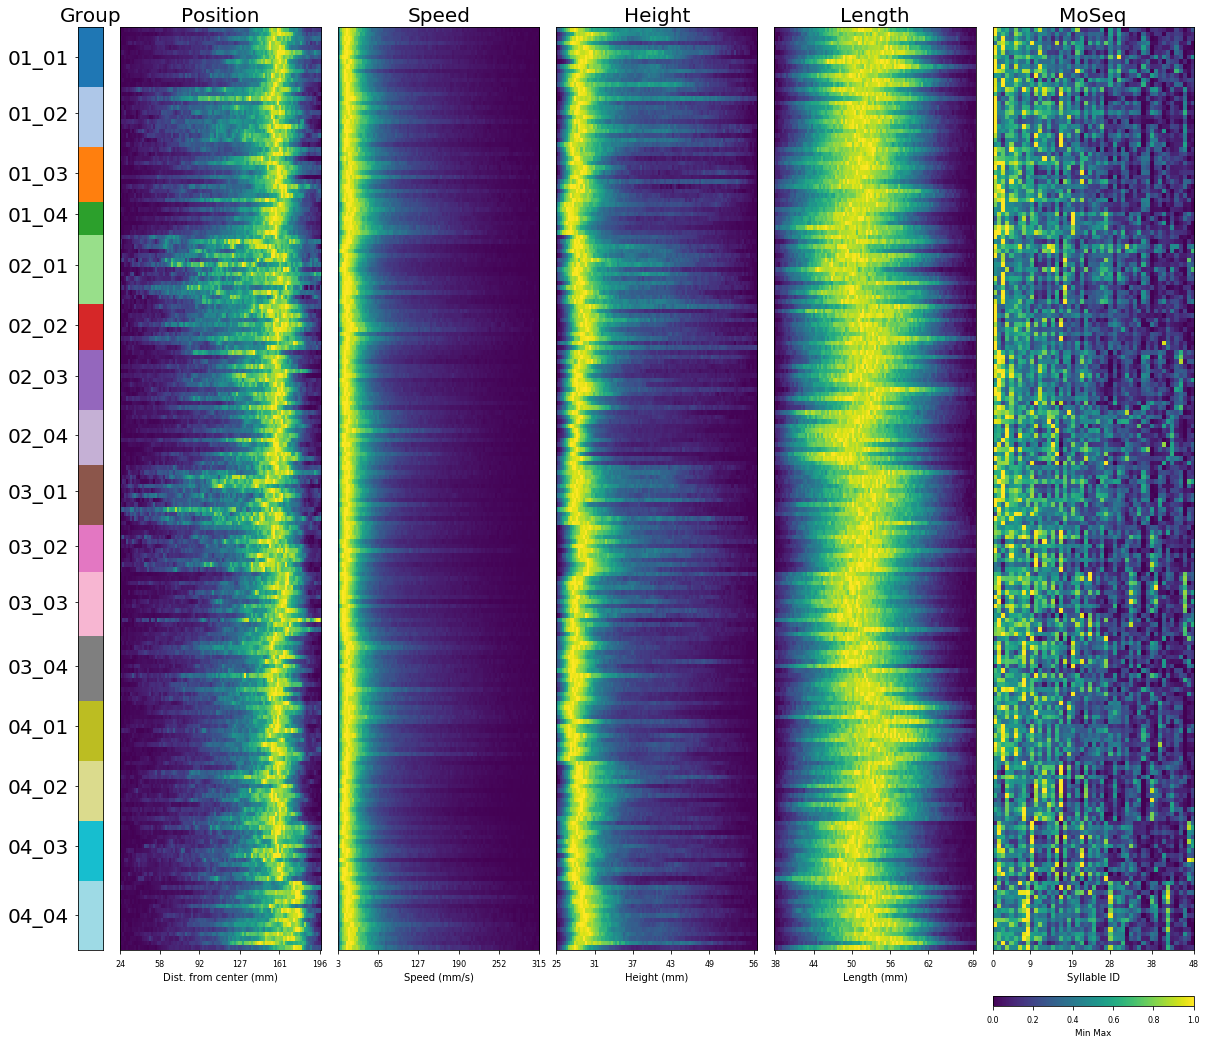

In [22]:
scalar_df['group'] = scalar_df['mouse'].copy()
mean_df['group'] = mean_df['mouse'].copy()

stat_type = 'mean'
n_bins = 100  # resolution of distribution 
range_type = 'robust'  # robust or full
preprocessor = MinMaxScaler()

summary, range_dict = create_fingerprint_dataframe(scalar_df, mean_df, stat_type=stat_type, n_bins=n_bins, 
                                                   range_type=range_type, groupby_list=['group', 'uuid'], 
                                                   scalars=['velocity_2d_mm', 'height_ave_mm', 'length_mm', 'dist_to_center_mm'])
                                                   
plotting_fingerprint(summary, './', range_dict, preprocessor=preprocessor)